# RL Experiments on TextFlappyBird environment

## Import all packages needed

In [1]:

import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
from abc import ABCMeta, abstractmethod

np.random.seed(43)

# Try the environment

In [2]:

# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
print(env.observation_space, env.action_space)


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


In [3]:
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[       

# Define Abstract BaseAgent class

In [4]:



class BaseAgent:
    """Implements the agent template."""
    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, *args, **kwargs):
        """Setup for the agent called when the experiment first starts."""
        pass
    
    @abstractmethod
    def get_pi(self, state, **kwargs):
        """Get the Agent policy in the given state"""
        pass

    @abstractmethod
    def get_action(self, state, **kwargs):
        """Get the Agent action in the given state"""
        pass
    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass




## We define our MonteCarlo $\epsilon$-greedy agent

In [5]:

class MCEpsilonGreedyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.Q = None
        self.returns = None
        self.policy = None
        self.epsilon = None
        self.alpha = None
        self.gamma = None
        self.nA = None

    def agent_init(self, num_states, num_actions,  epsilon=0.1, alpha=0.02, gamma=1):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.nA = num_actions
        self.nS = num_states
        self.Q = np.random.uniform(low=-1, high=1, size=(self.nS, self.nA))
        print(self.Q.shape)
    def get_pi(self, state, greedy=False):
        best_action = np.argmax(self.Q[state])
        if greedy:
            policy_s = np.zeros(self.nA)  # Corrected
            policy_s[best_action] = 1.0
            return policy_s
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        policy_s[best_action] += (1.0 - self.epsilon)
        return policy_s
    
    def get_action(self, observation, greedy=False):
        state = observation
        action = np.random.choice(np.arange(self.nA), p=self.get_pi(state, greedy=greedy))
        return action
    
    def update_Q(self, episode):
        G = 0
        visited = set()  # To track first-visit MC
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G  # Discounted return calculation
            
            # First-visit MC: Update Q only the first time we see (s,a)
            if (state, action) not in visited:
                visited.add((state, action))
                self.Q[state, action] += self.alpha * (G - self.Q[state, action])  # Update Q


    def agent_cleanup(self):
        self.Q.clear()
        self.returns.clear()

Let's try our agent

In [6]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
print(env.observation_space, env.action_space)
nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
w_offset = env.observation_space[1].start
number_states = nh * nw
num_actions = 2
episodes = 20000
mc_agent = MCEpsilonGreedyAgent()
mc_agent.agent_init(number_states, num_actions, epsilon=0.07, alpha=0.1, gamma=0.8)
def preprocess_state(state):
    return nw* state[0] + state[1]+ w_offset
pbar = tqdm(range(episodes))
logs_mc = []
for episode in pbar:
    episode_log = []
    obs,_ = env.reset()
    done=False
    i=0
    while not done:
        processed_obs = preprocess_state(obs)
        action = mc_agent.get_action(processed_obs)
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        episode_log.append((processed_obs, action, reward))
        i+=1
    mc_agent.update_Q(episode_log)
    logs_mc.append(i)
    pbar.set_description(str(i), refresh=False)

def geo_smooth(L, smooth_coef = 0.95):
    R = [L[0]]
    for i in range(1, len(L)):
        R.append(smooth_coef * R[-1] + (1-smooth_coef)* L[i])
    return R


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


93: 100%|██████████| 20000/20000 [00:32<00:00, 624.12it/s] 


Text(0, 0.5, 'Length of Episode')

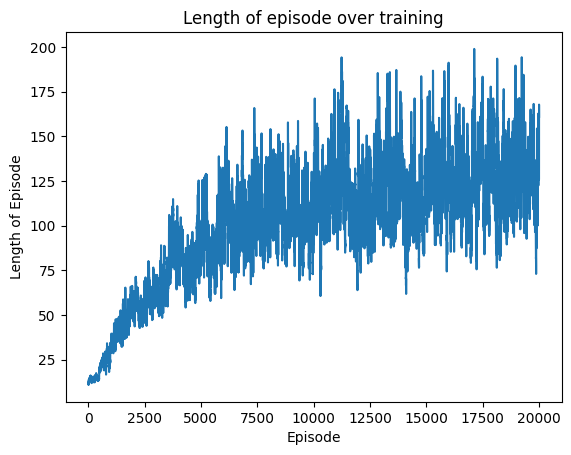

In [7]:
plt.plot(geo_smooth(logs_mc))
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")

Launch agent in greedy mode

In [8]:
nb_exp_greedy = 100
lengths = []
for _ in range(nb_exp_greedy):
    obs,_ = env.reset()
    i=0
    done = False
    while not done and i<1000:
        i+=1
        processed_obs = preprocess_state(obs)
        # Select next action
        action = mc_agent.get_action(processed_obs, greedy=True)
    
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
    lengths.append(i)
    env.close()
print("Greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Greedy mean achieved step 429.5


Check player

In [9]:
obs,_ = env.reset()
# iterate
done = False
i=0
while not done and i<50:
    i+=1
    processed_obs = preprocess_state(obs)
    # Select next action
    action = mc_agent.get_action(processed_obs, greedy=True)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[     

## We define our Sarsa($\lambda$)

In [10]:

class Sarsalambda(BaseAgent):
    def __init__(self):
        super().__init__()
        self.Q = None
        self.returns = None
        self.policy = None
        self.epsilon = None
        self.alpha = None
        self.gamma = None
        self.nA = None

    def agent_init(self, num_states, num_actions,  epsilon=0.1, alpha=0.02, gamma=1, lbd=1.):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.lbd = lbd
        self.nA = num_actions
        self.nS = num_states
        self.Q = np.random.uniform(low=-1, high=1, size=(self.nS, self.nA))
        self.traces = np.zeros((self.nS, self.nA))
    def get_pi(self, state, greedy=False):
        best_action = np.argmax(self.Q[state])
        if greedy:
            policy_s = np.zeros(self.nA) 
            policy_s[best_action] = 1.0
            return policy_s
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        policy_s[best_action] += (1.0 - self.epsilon)
        return policy_s
    
    def get_action(self, observation, greedy=False):
        state = observation
        action = np.random.choice(np.arange(self.nA), p=self.get_pi(state, greedy=greedy))
        return action
    def train_one_episode(self, env):
        obs,_ = env.reset()
        done=False
        i=0
        processed_obs = preprocess_state(obs)
        action = self.get_action(processed_obs)
        while not done:
            
            # Appy action and return new observation of the environment
            next_obs, reward, done, _, info = env.step(action)
            processed_next_obs = preprocess_state(next_obs)
            next_action = self.get_action(processed_next_obs)
            delta = reward + self.gamma * self.Q[processed_next_obs, next_action] - self.Q[processed_obs, action]
            self.traces[processed_obs, action] += 1 # Accumulating traces
            self.Q += self.alpha * delta * self.traces
            self.traces *= self.gamma * self.lbd
            i+=1
            action=next_action
            processed_obs = processed_next_obs
        return i
    def agent_cleanup(self):
        self.Q.clear()
        self.returns.clear()
        self.traces.clear()

In [11]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
print(env.observation_space, env.action_space)
nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
w_offset = env.observation_space[1].start
number_states = nh * nw
num_actions = 2
episodes = 20000
sr_agent = Sarsalambda()
sr_agent.agent_init(number_states, num_actions, epsilon=0.4, alpha=0.1, gamma=0.98, lbd=0.2)
pbar = tqdm(range(episodes))
logs_sr = []
for episode in pbar:
    
    
    i = sr_agent.train_one_episode(env)
    logs_sr.append(i)
    pbar.set_description(str(i), refresh=False)


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


11: 100%|██████████| 20000/20000 [00:10<00:00, 1833.10it/s] 


Text(0, 0.5, 'Length of Episode')

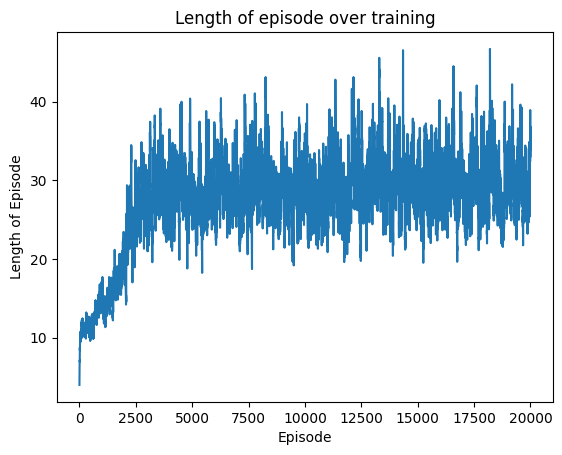

In [12]:

plt.plot(geo_smooth(logs_sr))
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")

In [13]:
nb_exp_greedy = 100
lengths = []
for _ in range(nb_exp_greedy):
    obs,_ = env.reset()
    i=0
    done = False
    while not done and i<1000:
        i+=1
        processed_obs = preprocess_state(obs)
        # Select next action
        action = sr_agent.get_action(processed_obs, greedy=True)
    
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
    lengths.append(i)
    env.close()
print("Greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Greedy mean achieved step 921.6


In [14]:
obs,_ = env.reset()
# iterate
done = False
i=0
while not done and i<50:
    i+=1
    processed_obs = preprocess_state(obs)
    # Select next action
    action = sr_agent.get_action(processed_obs, greedy=True)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[       

## Analysis of each agents state->action heatmap

**Monte Carlo Agent :**

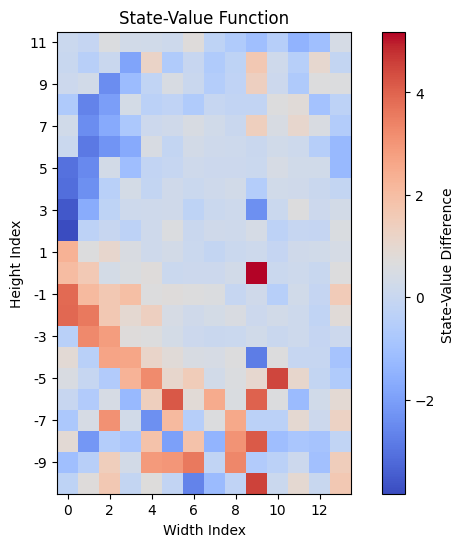

In [15]:

def get_2DQ(Q):
    Q_2D = np.zeros((nh, nw))
    for i in range(nh):
        for j in range(nw):
            Q_2D[i, j] = Q[nw * i + j,1] - Q[nw * i + j,0]
    return Q_2D

Q_mc = mc_agent.Q
Q_2D_mc = get_2DQ(Q_mc)
nx, ny = Q_2D_mc.shape

def plot_Q_2D(Q_2D, title="State-Value Function", cmap="coolwarm", offset=0):
    plt.figure(figsize=(8, 6))
    plt.imshow(Q_2D, cmap=cmap, origin="upper", interpolation="nearest")
    plt.colorbar(label="State-Value Difference ")
    y_ticks = np.arange(0, ny, 2)  # Ticks every 5 units (adjust as needed)
    y_labels = [f"{-i - offset}" for i in y_ticks]  # Modify y-labels with offset
    plt.yticks(y_ticks, y_labels)
    plt.xlabel("Width Index")
    plt.ylabel("Height Index")
    plt.title(title)
    plt.show()

plot_Q_2D(Q_2D_mc.transpose(), offset=w_offset)


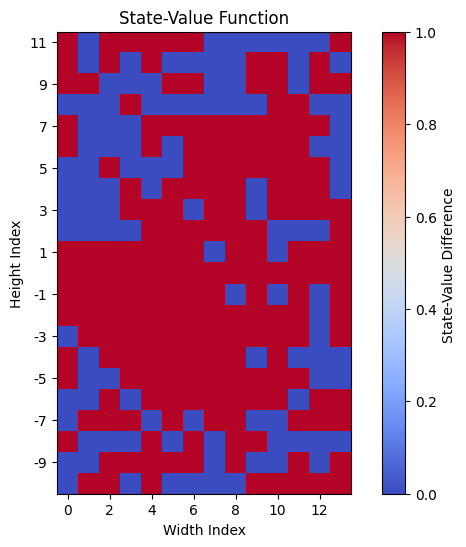

In [16]:
plot_Q_2D(Q_2D_mc.transpose()>=0, offset=w_offset)

**Sarsa Agent :**

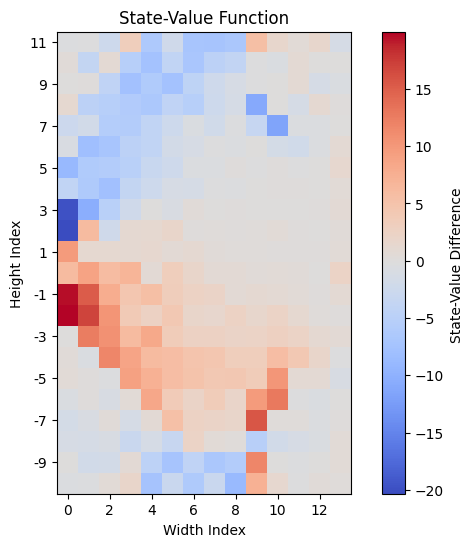

In [17]:
Q_sc = sr_agent.Q
Q_2D_sc = get_2DQ(Q_sc)
nx, ny = Q_2D_sc.shape

plot_Q_2D(Q_2D_sc.transpose(), offset=w_offset)


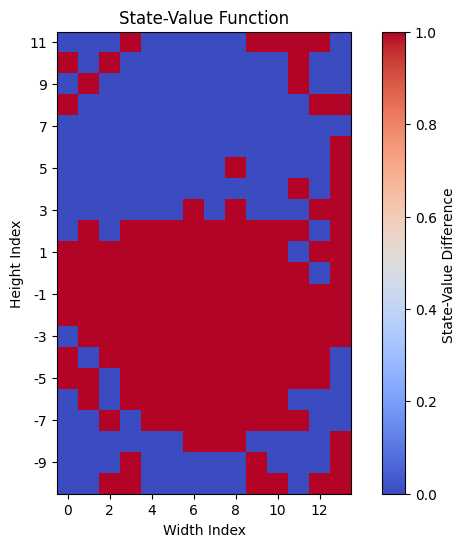

In [18]:
plot_Q_2D(Q_2D_sc.transpose()>=0, offset=w_offset)

## Parameter sweep graphs

### MonteCarlo

In [19]:
episodes = 20000

**Epsilon**

In [20]:
epsilons = [0.05,0.1,0.2,0.3,0.4]
logs = {}
agents = {}
for epsilon in epsilons:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    mc_agent = MCEpsilonGreedyAgent()
    mc_agent.agent_init(number_states, num_actions, epsilon=epsilon, alpha=0.1, gamma=0.9)
    def preprocess_state(state):
        return nw* state[0] + state[1]+ w_offset
    pbar = tqdm(range(episodes))
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = preprocess_state(obs)
            action = mc_agent.get_action(processed_obs)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i+=1
        mc_agent.update_Q(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[epsilon] = logs_mc
    agents[epsilon] = mc_agent
for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"epsilon : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


173: 100%|██████████| 20000/20000 [00:39<00:00, 508.10it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


83: 100%|██████████| 20000/20000 [00:25<00:00, 796.15it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


43: 100%|██████████| 20000/20000 [00:15<00:00, 1317.35it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


93: 100%|██████████| 20000/20000 [00:11<00:00, 1809.90it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


33:  26%|██▌       | 5246/20000 [00:02<00:06, 2374.55it/s]

KeyboardInterrupt



In [21]:
nb_exp_greedy = 1000
for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"epsilon : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

epsilon : 0.05 greedy mean achieved step 577.36
epsilon : 0.1 greedy mean achieved step 279.179
epsilon : 0.2 greedy mean achieved step 1000.0
epsilon : 0.3 greedy mean achieved step 298.12
epsilon : 0.4 greedy mean achieved step 402.434


Analysis :

Large epsilon seems to slow the learning of the Agent.

**Alpha**

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


63: 100%|██████████| 20000/20000 [00:10<00:00, 1896.70it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


33: 100%|██████████| 20000/20000 [00:21<00:00, 922.55it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


37: 100%|██████████| 20000/20000 [00:25<00:00, 769.48it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


53: 100%|██████████| 20000/20000 [00:23<00:00, 833.61it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


30: 100%|██████████| 20000/20000 [00:20<00:00, 982.98it/s]  


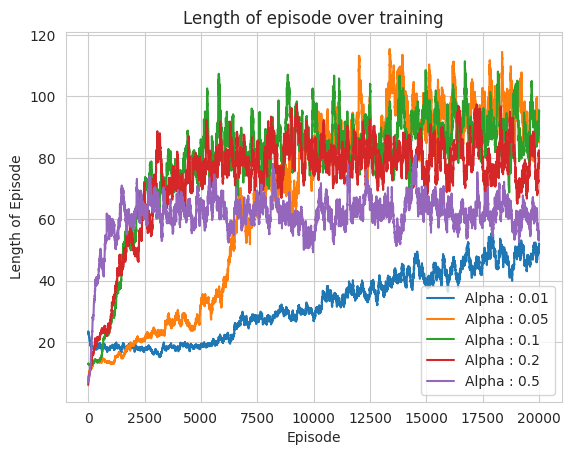

In [22]:
alphas=[0.01,0.05,0.1,0.2,0.5]
logs = {}
agents = {}
for alpha in alphas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    mc_agent = MCEpsilonGreedyAgent()
    mc_agent.agent_init(number_states, num_actions, epsilon=0.1, alpha=alpha, gamma=0.9)
    def preprocess_state(state):
        return nw* state[0] + state[1]+ w_offset
    pbar = tqdm(range(episodes))
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = preprocess_state(obs)
            action = mc_agent.get_action(processed_obs)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i+=1
        mc_agent.update_Q(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[alpha] = logs_mc
    agents[alpha] = mc_agent
    
for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Alpha : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

In [23]:
nb_exp_greedy = 1000


for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"Alpha : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Alpha : 0.01 greedy mean achieved step 185.975
Alpha : 0.05 greedy mean achieved step 786.833
Alpha : 0.1 greedy mean achieved step 715.784
Alpha : 0.2 greedy mean achieved step 399.353
Alpha : 0.5 greedy mean achieved step 235.212


Analysis :
* Large alpha seems to help the model learn much quicker.
* Too large alpha ($\alpha> 0.2$ seems to make the model have lower asymptotic results)

**Gamma**

In [ ]:
gammas=[0.1,0.5,0.8,0.9,0.95,0.99,1]
logs = {}
agents = {}
for gamma in gammas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    mc_agent = MCEpsilonGreedyAgent()
    mc_agent.agent_init(number_states, num_actions, epsilon=0.1, alpha=0.1, gamma=gamma)
    def preprocess_state(state):
        return nw* state[0] + state[1]+ w_offset
    pbar = tqdm(range(episodes))
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = preprocess_state(obs)
            action = mc_agent.get_action(processed_obs)
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i+=1
        mc_agent.update_Q(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[gamma] = logs_mc
    agents[gamma] = mc_agent
    
for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Gamma : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)
(308, 2)


23:  65%|██████▍   | 12922/20000 [00:03<00:03, 2201.65it/s]

In [151]:
nb_exp_greedy = 1000


for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"Gamma : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

epsilon : 0.1 greedy mean achieved step 92.054
epsilon : 0.5 greedy mean achieved step 223.969
epsilon : 0.8 greedy mean achieved step 1000.0
epsilon : 0.9 greedy mean achieved step 1000.0
epsilon : 0.95 greedy mean achieved step 80.384
epsilon : 0.99 greedy mean achieved step 311.334
epsilon : 1 greedy mean achieved step 498.302


Gamma : 

it does not seems to have a big impact as long as it is close to $1$ ($>0.5$)

## Sarsa($\lambda$)

In [162]:
episodes = 5000

**epsilon**

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


33: 100%|██████████| 5000/5000 [00:02<00:00, 1952.11it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


73: 100%|██████████| 5000/5000 [00:03<00:00, 1522.84it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


6: 100%|██████████| 5000/5000 [00:01<00:00, 2537.70it/s]  


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:02<00:00, 1737.32it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


13: 100%|██████████| 5000/5000 [00:02<00:00, 2448.17it/s]


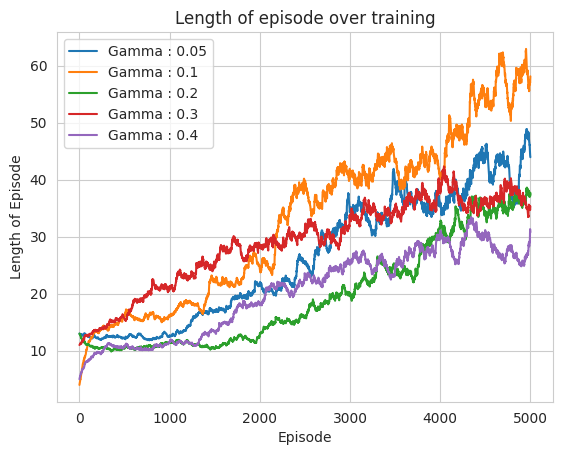

In [163]:
epsilons = [0.05,0.1,0.2,0.3,0.4]
logs = {}
agents = {}
for epsilon in epsilons:

    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    sr_agent = Sarsalambda()
    sr_agent.agent_init(number_states, num_actions, epsilon=epsilon, alpha=0.1, gamma=0.9, lbd=0.3)
    pbar = tqdm(range(episodes))
    logs_sr = []
    for episode in pbar:
        
        
        i = sr_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[epsilon] = logs_sr
    agents[epsilon] = sr_agent

for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Gamma : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

In [164]:
nb_exp_greedy = 1000

for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"epsilon : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

epsilon : 0.05 greedy mean achieved step 82.983
epsilon : 0.1 greedy mean achieved step 298.207
epsilon : 0.2 greedy mean achieved step 460.574
epsilon : 0.3 greedy mean achieved step 435.36
epsilon : 0.4 greedy mean achieved step 687.34


Analysis : Higher epsilon tends to help the Sarsa have better asymptotic results.

**Alpha**

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


11: 100%|██████████| 5000/5000 [00:01<00:00, 4145.15it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


23: 100%|██████████| 5000/5000 [00:01<00:00, 3927.01it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


12: 100%|██████████| 5000/5000 [00:03<00:00, 1648.54it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


53: 100%|██████████| 5000/5000 [00:03<00:00, 1471.66it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


53: 100%|██████████| 5000/5000 [00:04<00:00, 1008.23it/s] 


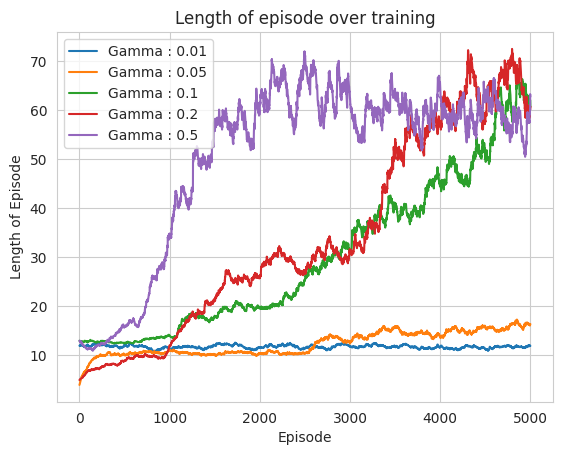

In [169]:
alphas=[0.01,0.05,0.1,0.2,0.5]
logs = {}
agents = {}
for alpha in alphas:

    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    sr_agent = Sarsalambda()
    sr_agent.agent_init(number_states, num_actions, epsilon=0.1, alpha=alpha, gamma=0.9, lbd=0.3)
    pbar = tqdm(range(episodes))
    logs_sr = []
    for episode in pbar:
        
        
        i = sr_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[alpha] = logs_sr
    agents[alpha] = sr_agent

for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Gamma : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

In [170]:
nb_exp_greedy = 1000

for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"Alpha : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Alpha : 0.01 greedy mean achieved step 11.782
Alpha : 0.05 greedy mean achieved step 20.767
Alpha : 0.1 greedy mean achieved step 298.874
Alpha : 0.2 greedy mean achieved step 819.411
Alpha : 0.5 greedy mean achieved step 178.295


**Gammas**

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


13: 100%|██████████| 5000/5000 [00:01<00:00, 3768.19it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


33: 100%|██████████| 5000/5000 [00:01<00:00, 3187.22it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


25: 100%|██████████| 5000/5000 [00:01<00:00, 3507.38it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:02<00:00, 2325.31it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


60: 100%|██████████| 5000/5000 [00:02<00:00, 2392.06it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


66: 100%|██████████| 5000/5000 [00:02<00:00, 1793.27it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


33: 100%|██████████| 5000/5000 [00:01<00:00, 3421.89it/s]


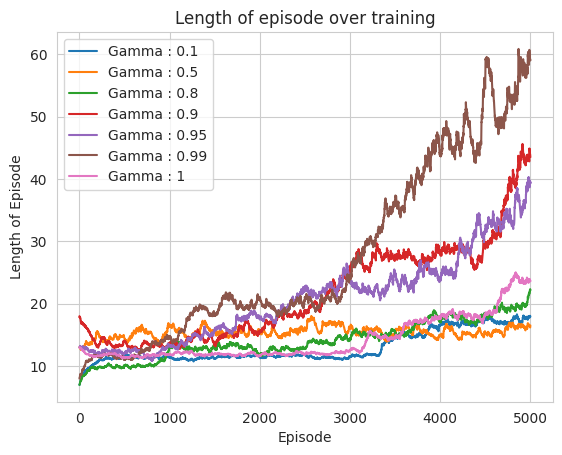

In [171]:
gammas=[0.1,0.5,0.8,0.9,0.95,0.99,1]
logs = {}
agents = {}
for gamma in gammas:

    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    sr_agent = Sarsalambda()
    sr_agent.agent_init(number_states, num_actions, epsilon=0.1, alpha=0.1, gamma=gamma, lbd=0.3)
    pbar = tqdm(range(episodes))
    logs_sr = []
    for episode in pbar:
        
        
        i = sr_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[gamma] = logs_sr
    agents[gamma] = sr_agent

for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Gamma : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

In [172]:
nb_exp_greedy = 1000

for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"Gamma : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Gamma : 0.1 greedy mean achieved step 19.832
Gamma : 0.5 greedy mean achieved step 19.244
Gamma : 0.8 greedy mean achieved step 24.403
Gamma : 0.9 greedy mean achieved step 95.935
Gamma : 0.95 greedy mean achieved step 111.476
Gamma : 0.99 greedy mean achieved step 394.27
Gamma : 1 greedy mean achieved step 36.818


**Lambda**

Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:03<00:00, 1505.12it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:03<00:00, 1633.45it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:03<00:00, 1649.73it/s] 


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


12: 100%|██████████| 5000/5000 [00:03<00:00, 1547.72it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


7: 100%|██████████| 5000/5000 [00:02<00:00, 1762.03it/s]  


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


43: 100%|██████████| 5000/5000 [00:02<00:00, 2310.75it/s]


Tuple(Discrete(14), Discrete(22, start=-11)) Discrete(2)


38: 100%|██████████| 5000/5000 [00:01<00:00, 2660.89it/s] 


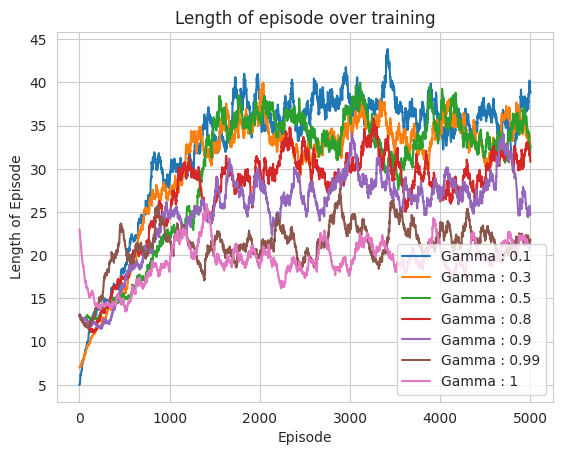

In [173]:
lambdas=[0.1,0.3,0.5,0.8,0.9,0.99,1]
logs = {}
agents = {}
for lbd in lambdas:

    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    print(env.observation_space, env.action_space)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    w_offset = env.observation_space[1].start
    number_states = nh * nw
    num_actions = 2
    sr_agent = Sarsalambda()
    sr_agent.agent_init(number_states, num_actions, epsilon=0.3, alpha=0.2, gamma=0.98, lbd=lbd)
    pbar = tqdm(range(episodes))
    logs_sr = []
    for episode in pbar:
        
        
        i = sr_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[lbd] = logs_sr
    agents[lbd] = sr_agent

for name,log in logs.items():
    plt.plot(geo_smooth(log, smooth_coef=0.99), label=f"Gamma : {name}")
plt.legend()
plt.title("Length of episode over training")
plt.xlabel("Episode")
plt.ylabel("Length of Episode")
plt.show()

In [174]:
nb_exp_greedy = 1000

for name,agent in agents.items():
    lengths = []
    for _ in range(nb_exp_greedy):
        obs,_ = env.reset()
        i=0
        done = False
        while not done and i<1000:
            i+=1
            processed_obs = preprocess_state(obs)
            # Select next action
            action = agent.get_action(processed_obs, greedy=True)
        
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
        lengths.append(i)
        env.close()
    print(f"Lambda : {name} greedy mean achieved step", sum(lengths) / nb_exp_greedy)

Lambda : 0.1 greedy mean achieved step 1000.0
Lambda : 0.3 greedy mean achieved step 278.192
Lambda : 0.5 greedy mean achieved step 318.835
Lambda : 0.8 greedy mean achieved step 82.89
Lambda : 0.9 greedy mean achieved step 129.561
Lambda : 0.99 greedy mean achieved step 29.183
Lambda : 1 greedy mean achieved step 46.453


Analysis : Low lambda seems to get better results.